In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [172]:
# import data

train = pd.read_csv('titanictrain.csv')
test = pd.read_csv('titanictest.csv')

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA

In [173]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [174]:
# number of nans in each column

train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

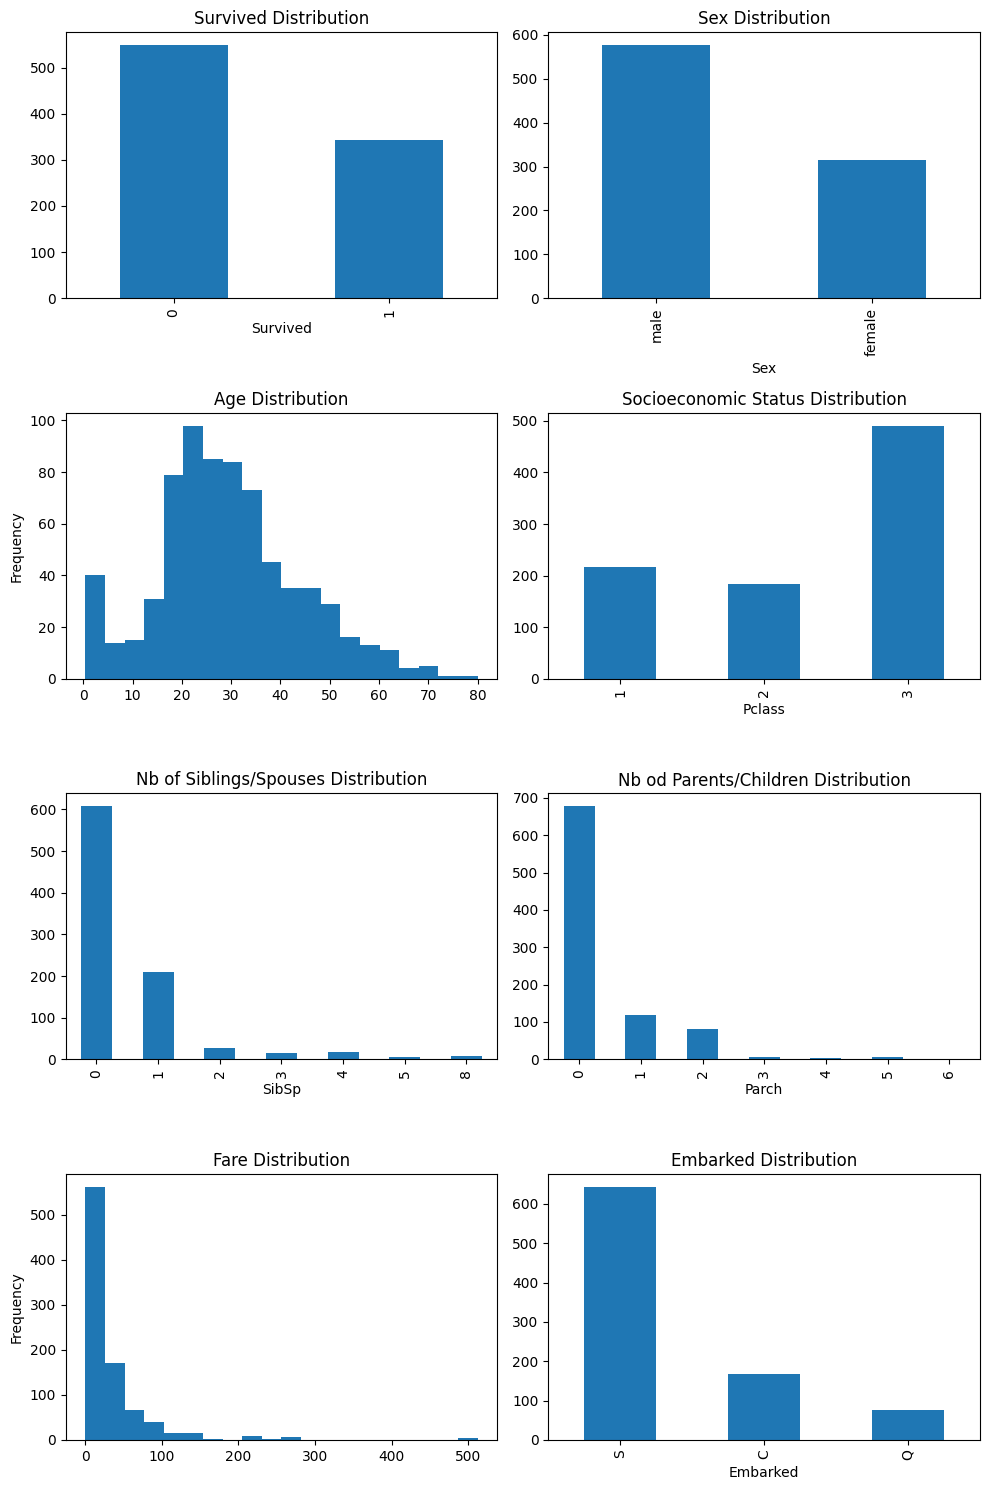

In [175]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(10, 15))

# Histograms of the data
train['Survived'].value_counts().plot(kind='bar', ax=axs[0, 0])
axs[0, 0].set_title('Survived Distribution')

train['Sex'].value_counts().plot(kind='bar', ax=axs[0, 1])
axs[0, 1].set_title('Sex Distribution')

train['Age'].plot(kind='hist', bins=20, ax=axs[1, 0])
axs[1, 0].set_title('Age Distribution')

train['Pclass'].value_counts().sort_index().plot(kind='bar', ax=axs[1, 1])
axs[1, 1].set_title('Socioeconomic Status Distribution')

train['SibSp'].value_counts().sort_index().plot(kind='bar', ax=axs[2, 0])
axs[2, 0].set_title('Nb of Siblings/Spouses Distribution')

train['Parch'].value_counts().sort_index().plot(kind='bar', ax=axs[2, 1])
axs[2, 1].set_title('Nb od Parents/Children Distribution')

train['Fare'].plot(kind='hist', bins=20, ax=axs[3, 0])
axs[3, 0].set_title('Fare Distribution')

train['Embarked'].value_counts().plot(kind='bar', ax=axs[3, 1])
axs[3, 1].set_title('Embarked Distribution')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [176]:
survived = train[train['Survived'] == 1]
died = train[train['Survived'] == 0]

list_surv=survived['Sex'].value_counts().tolist()
list_died=died['Sex'].value_counts().tolist()
keysdied=died['Sex'].value_counts().keys().tolist()
keyssurv=survived['Sex'].value_counts().keys().tolist()
#print(keyssurv)
#print(list_surv)
#print(keysdied)
#print(list_died)

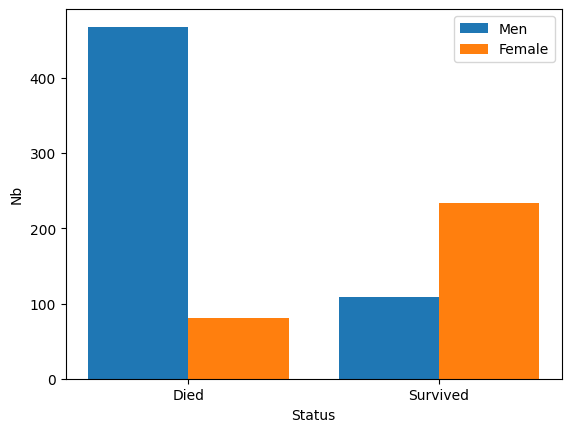

In [177]:
# survival distribution by sex

plt.figure()

status = ('Died','Survived')
y_pos = np.arange(len(status))

plt.bar(y_pos-0.2, [468,109], width=0.4)
plt.bar(y_pos+0.2, [81,233], width=0.4)
plt.xticks(y_pos, status)
plt.xlabel('Status')
plt.ylabel('Nb')
plt.legend(['Men', 'Female'])  

## Preprocessing

First stage: preprocessing consisted in transforming string categorical variables to numeric codes and dropping tickets and cabins

In [178]:
print(train['Name'].head(10))

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object


In [179]:
## divde names into title, first name and last name in a list

def split_nametitle(name):
    return name.split(',')[1].split('.')[0].strip()

def split_namefirst(name):
    return name.split(',')[0].strip()

def split_namelast(name):
    return name.split(',')[1].split('.')[1].strip()

train['Title'] = train['Name'].apply(split_nametitle)


#print train set with new columns
print(train.head(10))

test['Title'] = test['Name'].apply(split_nametitle)


#print test set with new columns
print(test.head(10))

#drop name columns from train and test

train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)




   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

In [181]:
# mr --> 0, miss --> 1, mrs --> 2, master --> 3, other --> 4

def title_to_num(title):
    if title == 'Mr':
        return 0
    elif title == 'Miss':
        return 1
    elif title == 'Mrs':
        return 2
    elif title == 'Master':
        return 3
    else:
        return 4
    
train['Title'] = train['Title'].apply(title_to_num)
test['Title'] = test['Title'].apply(title_to_num)

def sex_to_num(sex):
    if sex=='male':
        return 0
    else:
        return 1

train['Sex'] = train['Sex'].apply(sex_to_num)
test['Sex'] = test['Sex'].apply(sex_to_num)

# embarked: C --> 0, Q --> 1, S --> 2

def embarked_to_num(embarked):
    if embarked == 'C':
        return 0
    elif embarked == 'Q':
        return 1
    else:
        return 2

train['Embarked'] = train['Embarked'].apply(embarked_to_num)
test['Embarked'] = test['Embarked'].apply(embarked_to_num)

# drop ticket and cabin

train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)

print(train.head(10))
print(test.head(10))


   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  \
0            1         0       3    0  22.0      1      0   7.2500         2   
1            2         1       1    1  38.0      1      0  71.2833         0   
2            3         1       3    1  26.0      0      0   7.9250         2   
3            4         1       1    1  35.0      1      0  53.1000         2   
4            5         0       3    0  35.0      0      0   8.0500         2   
5            6         0       3    0   NaN      0      0   8.4583         1   
6            7         0       1    0  54.0      0      0  51.8625         2   
7            8         0       3    0   2.0      3      1  21.0750         2   
8            9         1       3    1  27.0      0      2  11.1333         2   
9           10         1       2    1  14.0      1      0  30.0708         0   

   Title  
0      0  
1      2  
2      1  
3      2  
4      0  
5      0  
6      0  
7      3  
8      2  
9      2 

<Axes: >

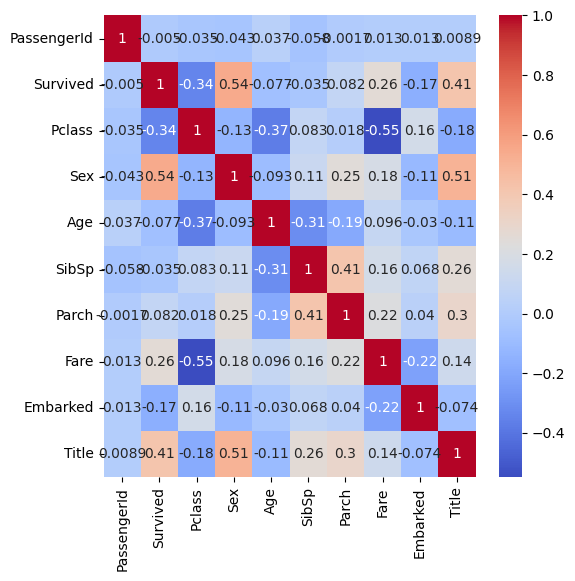

In [182]:
# heat matrix

import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')


In [145]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
Title            0
dtype: int64

In [146]:
# get copy of train and test
train_noNa = train.copy()
test_noNa = test.copy()


In [147]:
train_noNa['Embarked'].fillna(2, inplace=True)
test_noNa['Embarked'].fillna(2, inplace=True)
train_noNa['Age'].fillna(train_noNa['Age'].mean(), inplace=True)
test_noNa['Age'].fillna(test_noNa['Age'].mean(), inplace=True)

print(train_noNa.isnull().sum())
print(test_noNa.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
dtype: int64
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           1
Embarked       0
Title          0
dtype: int64


C:\Users\beama\AppData\Local\Temp\ipykernel_10088\3744989424.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_noNa['Embarked'].fillna(2, inplace=True)
C:\Users\beama\AppData\Local\Temp\ipykernel_10088\3744989424.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

## Sklearn Random Forests

In [148]:
# get vector of survived column
y = train['Survived'].values

# drop survived column
train = train.drop(columns=['Survived'])
train_noNa = train_noNa.drop(columns=['Survived'])

# drop ids

train = train.drop(columns=['PassengerId'])
train_noNa = train_noNa.drop(columns=['PassengerId'])
testf = test.copy()
testf = testf.drop(columns=['PassengerId'])
test_noNaf = test_noNa.copy()
test_noNaf = test_noNaf.drop(columns=['PassengerId'])

Default RF

In [149]:
def def_rf(train,y):
    clf = RandomForestClassifier(random_state=0)
    clf.fit(train, y)
    scores = cross_val_score(clf, train, y, cv=5)
    return clf,scores.mean()

In [150]:
model_defRF,scores_defRF = def_rf(train,y)
print(scores_defRF)

0.8215680120519743


In [152]:
model2_defRF,scores2_defRF = def_rf(train_noNa,y)
print(scores2_defRF)

0.8069675475488042


Hyperparameter tuning RF

In [156]:
def random_grid():
    clf = RandomForestClassifier(random_state=0)
    n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
    max_features = ['log2', 'sqrt', None]
    max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
    min_samples_split = [2, 5, 10, 20]
    min_samples_leaf = [1, 2, 4, 8]
    min_samples_split = [2, 5, 10, 20]
    min_samples_leaf = [1, 2, 4, 8]
    bootstrap = [True, False] # if false the whole dataset is used to build each tree
    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}
    return random_grid

def random_search(grid,train,y):
    clf = RandomForestClassifier(random_state=0)
    clf_random = RandomizedSearchCV(estimator=clf, param_distributions=grid, n_iter=100, cv=3, verbose=2, random_state=0, n_jobs=-1)
    clf_random.fit(train, y)
    return clf_random.best_params_,clf_random.best_score_

# function that trains with best parameters

def best_rf(best_params,train,y):
    n_estimators = best_params['n_estimators']
    max_depth = best_params['max_depth']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_features = best_params['max_features']
    bootstrap = best_params['bootstrap']

    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap=bootstrap, random_state=0)
    clf.fit(train, y)

    scores = cross_val_score(clf, train, y, cv=8)

    return clf,scores.mean()

def randompredict(clf,test,OGtest):
    pred = clf.predict(test)
    final_preds = np.column_stack((np.array(OGtest['PassengerId']), np.array(pred)))  
    print(final_preds.shape)
    return final_preds
        

In [88]:
grid = random_grid()
search = random_search(grid,train,y)
print(search)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
({'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 60, 'bootstrap': True}, 0.8316498316498316)


In [89]:
best_randommodel = best_rf(search[0],train,y)
print(best_randommodel[1])

0.8316678174628084


In [113]:
preds = randompredict(best_randommodel[0],testf,test)
np.savetxt('titanicpreds.csv', preds, delimiter=',', fmt='%i', header='PassengerId,Survived', comments='') #got 0.77990 (lower)

(418, 2)


In [153]:
# do the same for no NA

grid2 = random_grid()
search2 = random_search(grid2,train_noNa,y)
print(search2)

best_randommodel2 = best_rf(search2[0],train_noNa,y)
print(best_randommodel2[1])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
({'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 100, 'bootstrap': True}, 0.8439955106621774)
0.8383968363567886


In [155]:
predsnona = randompredict(best_randommodel2[0],test_noNaf,test_noNa)
np.savetxt('titanicpredsnona.csv', predsnona, delimiter=',', fmt='%i', header='PassengerId,Survived', comments='') 

(418, 2)


Using GridSearch based on the RandomSearch results

In [114]:
# manually build grid

param_grid = {'n_estimators': [500, 600, 700],
                'max_features': [None],
                'max_depth': [50, 60, 70],
                'min_samples_split': [4, 5, 6],
                'min_samples_leaf': [1, 2, 3],
                'bootstrap': [True]} 


In [119]:
def gridsearch(grid,train,y):
    clf = RandomForestClassifier(random_state=0)
    clf_grid = GridSearchCV(estimator=clf, param_grid=grid, cv=3, verbose=2, n_jobs=-1)
    clf_grid.fit(train, y)
    return clf_grid.best_params_,clf_grid.best_score_

def gridsearch_best(best_params,train,y):
    n_estimators = best_params['n_estimators']
    max_depth = best_params['max_depth']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_features = best_params['max_features']
    bootstrap = best_params['bootstrap']

    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap=bootstrap, random_state=0)
    clf.fit(train, y)

    scores = cross_val_score(clf, train, y, cv=5)

    return clf,scores.mean() 

def gridpredict(clf,test,OGtest):
    pred = clf.predict(test)
    final_preds = np.column_stack((np.array(OGtest['PassengerId']), np.array(pred)))  
    print(final_preds.shape)
    return final_preds  

In [116]:
allsearch = gridsearch(param_grid,train,y)
print(allsearch)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
({'bootstrap': True, 'max_depth': 50, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 700}, 0.8338945005611672)


In [157]:
best_gridmodel = gridsearch_best(allsearch[0],train,y)
print(best_gridmodel[1])

0.8294206264515724


In [132]:
predsgrid = gridpredict(best_gridmodel[0],testf,test)
np.savetxt('titanicpredsgrid.csv', predsgrid, delimiter=',', fmt='%i', header='PassengerId,Survived', comments='') 

(418, 2)


alternative

In [219]:
# create parameter grid based on the random search results

param_grid = {'n_estimators': [400,500, 600, 700,800],
                'max_features': ['log2'],
                'max_depth': [40,50, 60, 70, 80, 90],
                'min_samples_split': [3, 4, 5, 6, 7],
                'min_samples_leaf': [1, 2, 3, 4],
                'bootstrap': [True]}

rf = RandomForestClassifier()

model_gridRF = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)


In [220]:
model_gridRF.fit(train, y)
model_gridRF.best_params_
model_gridRF.best_score_

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


0.8383838383838383

In [221]:
# print best hyperparameters

print(model_gridRF.best_params_)



{'bootstrap': True, 'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 700}


In [129]:
best_grid = {'n_estimators': 700,
                'max_features': 'log2',
                'max_depth': 40,
                'min_samples_split': 3,
                'min_samples_leaf': 1,
                'bootstrap': True}

In [131]:
# train with best grid

best_gridmodel = best_rf(best_grid,train,y)
print(best_gridmodel[1])

# predict with best grid

predsgrid2 = gridpredict(best_gridmodel[0],testf,test)
np.savetxt('titanicpredsgrid2.csv', predsgrid2, delimiter=',', fmt='%i', header='PassengerId,Survived', comments='')

0.8226978846274559
(418, 2)


In [223]:
# train with best

model_bestgridRF = RandomForestClassifier(n_estimators=700, min_samples_split=3, min_samples_leaf=1, max_features='log2', max_depth=40, bootstrap=True, random_state=0)
model_bestgridRF.fit(train, y)

# cross validation

scores = cross_val_score(model_bestgridRF, train, y, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.80


best pred so far

In [231]:
#predict

predictions = model_gridRF.predict(test)
print(test.shape)
print(predictions.shape)

final_preds = np.column_stack((np.array(test['PassengerId']), np.array(predictions)))  
print(final_preds.shape)

# final preds to csv

np.savetxt('final_preds.csv', final_preds, delimiter=',', fmt='%s', header='PassengerId,Survived', comments='') # got 0.79425

(418, 9)
(418,)
(418, 2)


## Using HistGradientBoostingClassifier

In [158]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=0)

# no NA

X_trainnoNa, X_testnoNa, y_trainnoNa, y_testnoNa = train_test_split(train_noNa, y, test_size=0.2, random_state=0)

In [159]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier(max_iter=1000,  # Maximum number of iterations
                                     early_stopping=True,  # Enable early stopping
                                     validation_fraction=0.1,  # Fraction of training data to use as validation set
                                     n_iter_no_change=5,  # Number of iterations with no improvement to wait before stopping
                                     tol=1e-3,  # Tolerance for the early stopping
                                     verbose=1)  # Verbosity level

clf.fit(X_train, y_train)

# score

print("Validation accuracy: ", clf.score(X_test, y_test))



c:\Users\beama\OneDrive\Documents\personal projects\ppvenv\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Binning 0.000 GB of training data: 0.007 s
Binning 0.000 GB of validation data: 0.000 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 24 leaves, max depth = 7, train loss: 0.61628, val loss: 0.63128, in 0.026s
[2/1000] 1 tree, 25 leaves, max depth = 8, train loss: 0.57672, val loss: 0.60408, in 0.006s
[3/1000] 1 tree, 25 leaves, max depth = 8, train loss: 0.54419, val loss: 0.58151, in 0.003s
[4/1000] 1 tree, 25 leaves, max depth = 8, train loss: 0.51696, val loss: 0.56378, in 0.003s
[5/1000] 1 tree, 25 leaves, max depth = 8, train loss: 0.49365, val loss: 0.54959, in 0.009s
[6/1000] 1 tree, 24 leaves, max depth = 8, train loss: 0.47423, val loss: 0.53835, in 0.006s
[7/1000] 1 tree, 25 leaves, max depth = 7, train loss: 0.45655, val loss: 0.52546, in 0.004s
[8/1000] 1 tree, 25 leaves, max depth = 8, train loss: 0.44083, val loss: 0.51441, in 0.007s
[9/1000] 1 tree, 23 leaves, max depth = 7, train loss: 0.42741, val loss: 0.50541, in 0.005s
[10/1000] 1 tree, 24 leaves, max depth = 8

In [162]:
print("Validation accuracy: ", clf.score(X_test, y_test))

# cross validation

scores = cross_val_score(clf, train, y, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())


Validation accuracy:  0.8435754189944135
Binning 0.000 GB of training data: 0.002 s
Binning 0.000 GB of validation data: 0.000 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 24 leaves, max depth = 7, train loss: 0.61451, val loss: 0.62958, in 0.004s
[2/1000] 1 tree, 24 leaves, max depth = 7, train loss: 0.57370, val loss: 0.60004, in 0.003s
[3/1000] 1 tree, 24 leaves, max depth = 7, train loss: 0.54043, val loss: 0.57392, in 0.011s
[4/1000] 1 tree, 25 leaves, max depth = 7, train loss: 0.51239, val loss: 0.55169, in 0.004s
[5/1000] 1 tree, 25 leaves, max depth = 8, train loss: 0.48789, val loss: 0.53314, in 0.003s
[6/1000] 1 tree, 25 leaves, max depth = 7, train loss: 0.46767, val loss: 0.52027, in 0.004s
[7/1000] 1 tree, 23 leaves, max depth = 8, train loss: 0.44912, val loss: 0.50750, in 0.004s
[8/1000] 1 tree, 25 leaves, max depth = 7, train loss: 0.43402, val loss: 0.49742, in 0.003s
[9/1000] 1 tree, 25 leaves, max depth = 7, train loss: 0.42013, val loss: 0.48846, in 0.003s
[

1 tree, 25 leaves, max depth = 7, train loss: 0.36240, val loss: 0.45678, in 0.008s
[16/1000] 1 tree, 24 leaves, max depth = 10, train loss: 0.35566, val loss: 0.45234, in 0.005s
[17/1000] 1 tree, 25 leaves, max depth = 7, train loss: 0.34967, val loss: 0.44802, in 0.003s
[18/1000] 1 tree, 26 leaves, max depth = 8, train loss: 0.34327, val loss: 0.44492, in 0.006s
[19/1000] 1 tree, 25 leaves, max depth = 9, train loss: 0.33766, val loss: 0.44109, in 0.004s
[20/1000] 1 tree, 25 leaves, max depth = 11, train loss: 0.33237, val loss: 0.43755, in 0.005s
[21/1000] 1 tree, 25 leaves, max depth = 8, train loss: 0.32687, val loss: 0.43431, in 0.006s
[22/1000] 1 tree, 26 leaves, max depth = 8, train loss: 0.32160, val loss: 0.43069, in 0.022s
[23/1000] 1 tree, 25 leaves, max depth = 8, train loss: 0.31658, val loss: 0.42683, in 0.004s
[24/1000] 1 tree, 27 leaves, max depth = 9, train loss: 0.31213, val loss: 0.42335, in 0.004s
[25/1000] 1 tree, 25 leaves, max depth = 9, train loss: 0.30827, val

In [164]:
test = test.drop

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,0,34.5,0,0,7.8292,1,0
1,893,3,1,47.0,1,0,7.0000,2,2
2,894,2,0,62.0,0,0,9.6875,1,0
3,895,3,0,27.0,0,0,8.6625,2,0
4,896,3,1,22.0,1,1,12.2875,2,2


In [165]:
# predict 

predictions = clf.predict(testf)
print(testf.shape)
print(predictions.shape)

final_preds = np.column_stack((np.array(test['PassengerId']), np.array(predictions)))
print(final_preds.shape)

# final preds to csv

np.savetxt('final_GBT.csv', final_preds, delimiter=',', fmt='%s', header='PassengerId,Survived', comments='') # got 0.79425

(418, 8)
(418,)
(418, 2)
